# Spatial convergence of PetIBM

**WARNING**: this notebook uses functions, classes, and methods from my Python package *scripts* that can be found [here](https://github.com/mesnardo/scripts).
If you want to run the content of this notebook: download the repository [*scripts*](https://github.com/mesnardo/scripts) and setup the environment variable `SCRIPTS` in your shell.

**Notes**: in this notebook, I am comparing the solution obtained with PetIBM and with the cuIBM one. Before doing this, I checked that the matrices of the different systems generated by the two codes were the same. I also looked into PetIBM to catch possible bugs but could not find one. (This does not mean there is no bug, it just means I could not find one.)

PetIBM has been compiled with `PETSc-3.5.2`.

cuIBM has been compiled with `nvcc-7.5` and `CUSP-0.5.1`.

All tests presented below have been run on `Phantom`.

In [1]:
import os
import sys

from IPython.display import display, Image
import numpy
from matplotlib import pyplot
pyplot.style.use('{}/styles/'
                 'mesnardo.mplstyle'.format(os.environ['SCRIPTS']))
%matplotlib inline

sys.path.append(os.environ['SCRIPTS'])
from library.simulation import Simulation
from library.field import Field

The cell below displays the commit of the repositoy [*scripts*](https://github.com/mesnardo/scripts) that is used to run this notebook.

In [2]:
%%bash 
git --git-dir $HOME/git/mesnardo/scripts/.git log -n 1

commit 52dc5ab05a04fcee24124c78e55206e8ce733354
Author: mesnardo <mesnardo@gwu.edu>
Date:   Mon Mar 28 17:21:36 2016 -0400

    Fill notebook with text and compute contents


# The test-case: 2d lid-driven cavity flow

We want to show that the Navier-Stokes solver implemented in PetIBM is second-order accurate in space in the absence of an immersed boundary.

We choose the test-case of the two-dimensional lid-driven cavity flow. The top side of the unit-square cavity ($[0, 1]\times[0, 1]$) moves with speed $1.0$ in the x-direction. The Reynolds number, based on the lid-speed , the cavity side-length, and the kinematic viscosity, is set to $100.0$.

To investigate the spatial order of convergence, we compute the solution on five grids consecutively refined with a ratio of $3$: $20\times20$, $60\times60$, $180\times180$, $540\times540$, and $1620\times1620$.

For each simulation, we compute $500$ time-steps with time-increment $\Delta t = 5.0\times10^{-4}$. The convective terms and the diffusive terms are treated explicitly and implecitly, respectively.

All spatial derivatives are approximated with second-order accurate central differences.

We choose to solve the velocity with a biconjugate-gradient stabilized that is diagonally preconditioned. We fix the exit criterion of the solver with an absolute tolerance of $10^{-12}$.
For the Poisson system, we use a conjugate-gradient algorithm with a GAMG preconditioner. The solver is said to have convergence when the absolute residual is smaller than $10^{-12}$.

We repeated the simulations using cuIBM, another code that implements the method but uses the library CUSP to iteratively solve the systems on GPU.

In [3]:
cuibm_series_directory = ('{}/tmp/convergence_cuIBM/lidDrivenCavity20_atol12'
                          ''.format(os.environ['HOME']))
petibm_series_directory = ('{}/tmp/convergence_PetIBM/lidDrivenCavity20_atol12'
                           ''.format(os.environ['HOME']))

We compute the observed order of convergence in space using the solution on three consecutive grids, as follow:

$$
\alpha = \log \left( \frac{\parallel f_{180} - f_{60} \parallel}{\parallel f_{540} - f_{180} \parallel} \right) /\log \left( 3 \right)
$$

where $\parallel . \parallel$ represents the $L_2$-norm, $f$ the quantity of interest, and the subscript determines the number of cells along one direction (e.g. $f_{180}$ is the solution of the quantity $f$ on the uniform grid $180\times180$).

The table below reports the orders of convergence for the velocity components ($u$ and $v$) and the pressure ($p$) observed with PetIBM (first row) and cuIBM (second row) . The suffixes "first", "middle", and "last" represent which trio of consecutive grids has been used:
* "first": $20\times20$, $60\times60$, and $180\times180$;
* "middle": $60\times60$, $180\times180$;, and $540\times540$;
* "last": $180\times180$, $540\times540$, and $1620\times1620$.

| time-step | u-first | u-middle | u-last | v-first | v-middle | v-last | p-first | p-middle | p-last |
|---|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| 500 | 1.7704 | 2.1153 | -0.3919 | 1.5688 | 2.0317 | 0.7289 | 1.5684 | 1.964 | 1.8199 |
| 500 | 1.7695 | 2.116 | 1.9837 | 1.5663 | 2.037 | 1.9341 | 1.5703 | 1.9638 | 1.8206 |


The orders of convergence obtained with PetIBM do not match the cuIBM ones when using the last three grids. This observation applies only to the velocity components , not the pressure.

The figures below show the differences in the solution, after $500$ time-steps, between a grid and the finest grid when solving with PetIBM (top) and cuIBM (bottom).

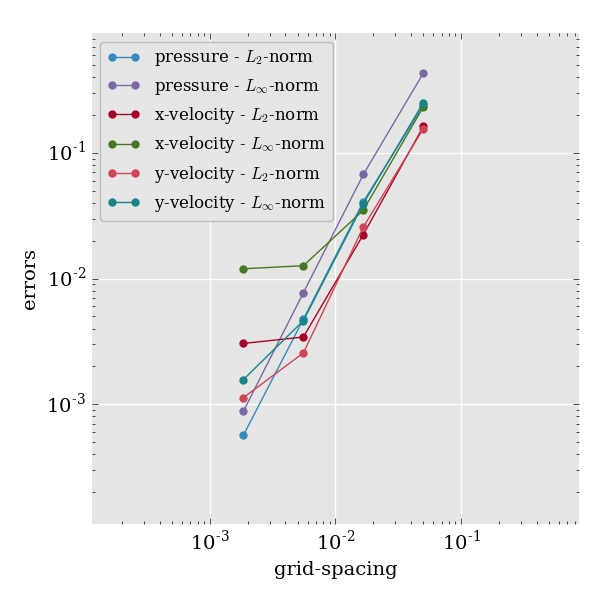

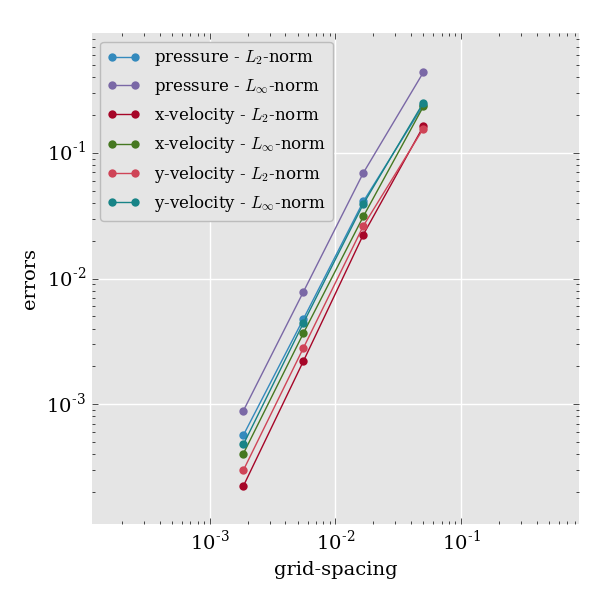

In [4]:
display(Image('{}/images/gridConvergence0000500.png'
              ''.format(petibm_series_directory)))
display(Image('{}/images/gridConvergence0000500.png'
              ''.format(cuibm_series_directory)))

**Question: why do we get second-order convergence in space with cuIBM and not with PetIBM?**

# grid: 20x20

In [5]:
gridline_size = 20
# create cuIBM case and read velocity from files
cuibm_directory = '{}/{}'.format(cuibm_series_directory, gridline_size)
cuibm20 = Simulation(software='cuibm', 
                     description='cuIBM', 
                     directory=cuibm_directory)
cuibm20.read_grid()
cuibm20.read_fields(['x-velocity', 'y-velocity'], 500)
# create PetIBM case and read velocity from files
petibm_directory = '{}/{}'.format(petibm_series_directory, gridline_size)
petibm20 = Simulation(software='petibm', 
                      description='PetIBM',
                      directory=petibm_directory)
petibm20.read_grid()
petibm20.read_fields(['x-velocity', 'y-velocity'], 500)
# subtract cuIBM solution from PetIBM one
petibm20.subtract(cuibm20, 'x-velocity')
petibm20.subtract(cuibm20, 'y-velocity')

[info] registering simulation ...
	- directory: /home/mesnardo/tmp/convergence_cuIBM/lidDrivenCavity20_atol12/20
	- description: cuIBM
	- software: cuibm
[info] reading grid from file ... done
[time-step 500] reading velocity field from file ... done
[info] registering simulation ...
	- directory: /home/mesnardo/tmp/convergence_PetIBM/lidDrivenCavity20_atol12/20
	- description: PetIBM
	- software: petibm
[info] reading the grid ... done
[time-step 500] reading velocity field ... done
x_velocity_subtracted
y_velocity_subtracted


[info] plotting field values along vertical gridline(s) ... done
[info] plotting field values along vertical gridline(s) ... done


/home/mesnardo/src/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


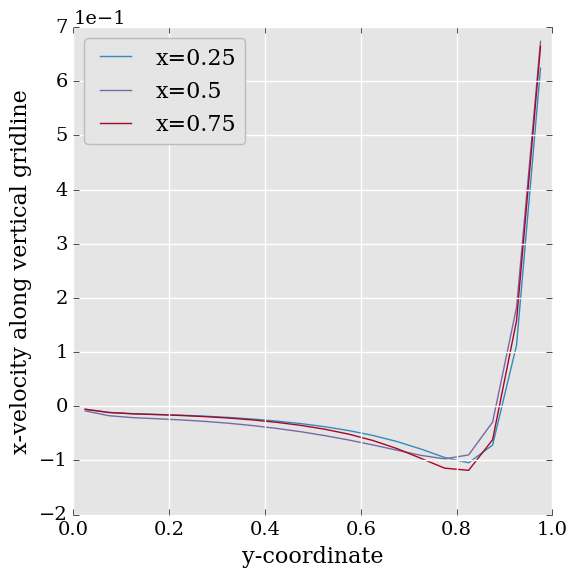

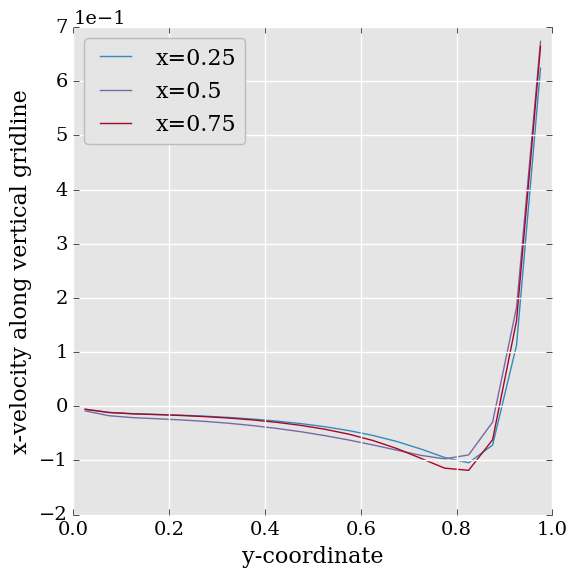

In [6]:
# plot x-velocity along vertical gridline
cuibm20.x_velocity.plot_vertical_gridline_values([0.25, 0.5, 0.75])
petibm20.x_velocity.plot_vertical_gridline_values([0.25, 0.5, 0.75])

[info] plotting field values along vertical gridline(s) ... done


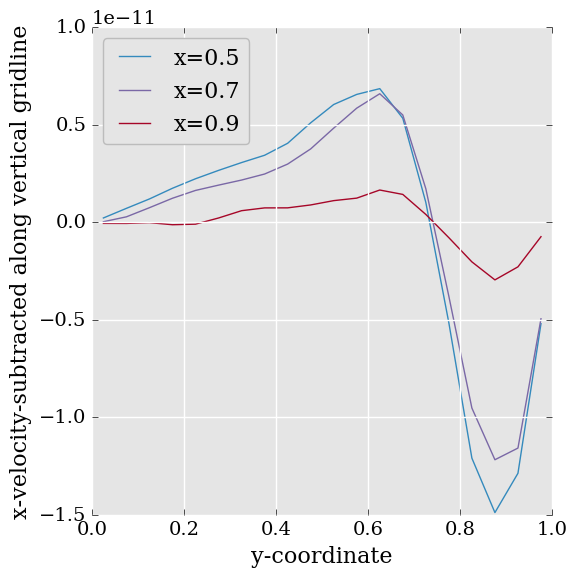

In [7]:
# plot subtracted x-velocity along vertical gridlines
petibm20.x_velocity_subtracted.plot_vertical_gridline_values([0.5, 0.7, 0.9])

[info] plotting field values along horizontal gridline(s) ... done
[info] plotting field values along horizontal gridline(s) ... done


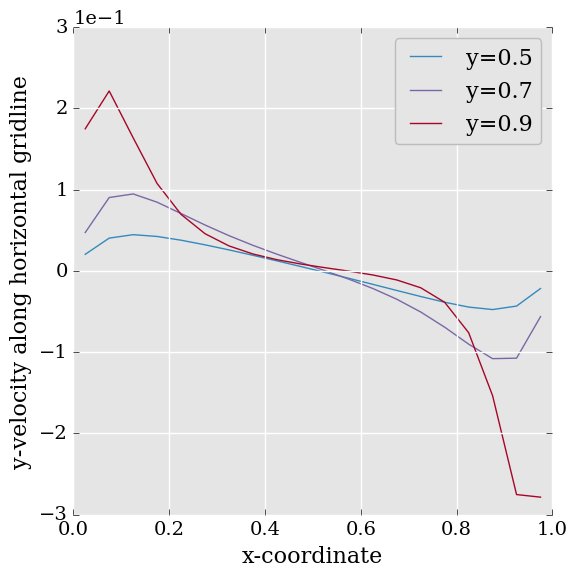

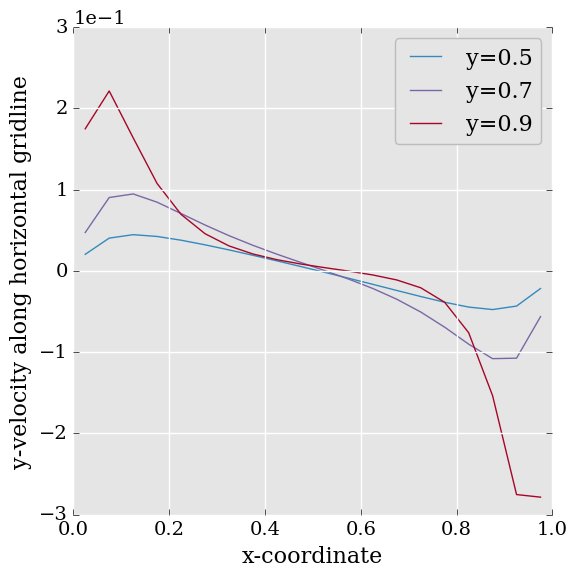

In [8]:
# plot y-velocity along horizontal gridline
cuibm20.y_velocity.plot_horizontal_gridline_values([0.5, 0.7, 0.9])
petibm20.y_velocity.plot_horizontal_gridline_values([0.5, 0.7, 0.9])

[info] plotting field values along horizontal gridline(s) ... done


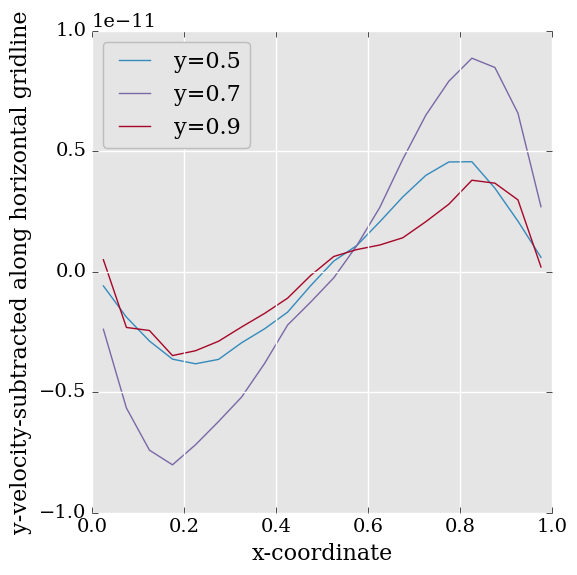

In [9]:
# plot subtracted y-velocity along horizontal gridlines
petibm20.y_velocity_subtracted.plot_horizontal_gridline_values([0.5, 0.7, 0.9])

# grid: 60x60

In [10]:
gridline_size = 60
# create cuIBM case and read velocity from files
cuibm_directory = '{}/{}'.format(cuibm_series_directory, gridline_size)
cuibm60 = Simulation(software='cuibm', 
                     description='cuIBM', 
                     directory=cuibm_directory)
cuibm60.read_grid()
cuibm60.read_fields(['x-velocity', 'y-velocity'], 500)
# create PetIBM case and read velocity from files
petibm_directory = '{}/{}'.format(petibm_series_directory, gridline_size)
petibm60 = Simulation(software='petibm', 
                      description='PetIBM',
                      directory=petibm_directory)
petibm60.read_grid()
petibm60.read_fields(['x-velocity', 'y-velocity'], 500)
# subtract cuIBM solution from PetIBM one
petibm60.subtract(cuibm60, 'x-velocity')
petibm60.subtract(cuibm60, 'y-velocity')

[info] registering simulation ...
	- directory: /home/mesnardo/tmp/convergence_cuIBM/lidDrivenCavity20_atol12/60
	- description: cuIBM
	- software: cuibm
[info] reading grid from file ... done
[time-step 500] reading velocity field from file ... done
[info] registering simulation ...
	- directory: /home/mesnardo/tmp/convergence_PetIBM/lidDrivenCavity20_atol12/60
	- description: PetIBM
	- software: petibm
[info] reading the grid ... done
[time-step 500] reading velocity field ... done
x_velocity_subtracted
y_velocity_subtracted


[info] plotting field values along vertical gridline(s) ... done
[info] plotting field values along vertical gridline(s) ... done


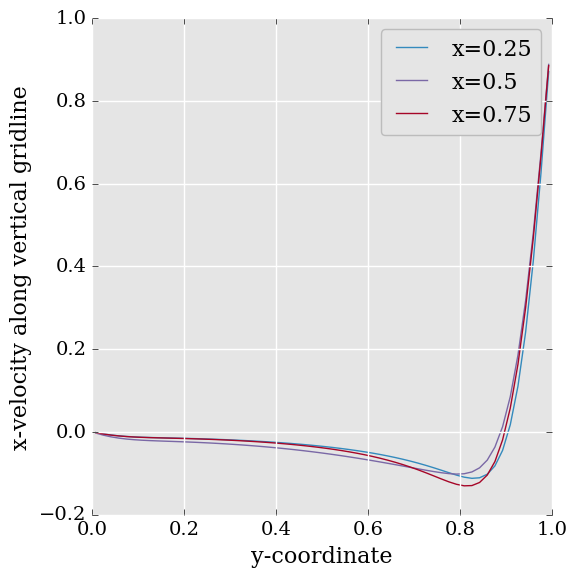

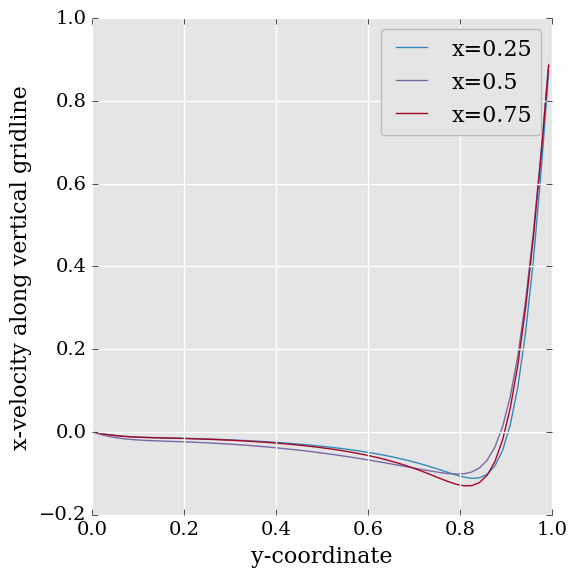

In [11]:
# plot x-velocity along vertical gridlines
cuibm60.x_velocity.plot_vertical_gridline_values([0.25, 0.50, 0.75])
petibm60.x_velocity.plot_vertical_gridline_values([0.25, 0.50, 0.75])

[info] plotting field values along vertical gridline(s) ... done


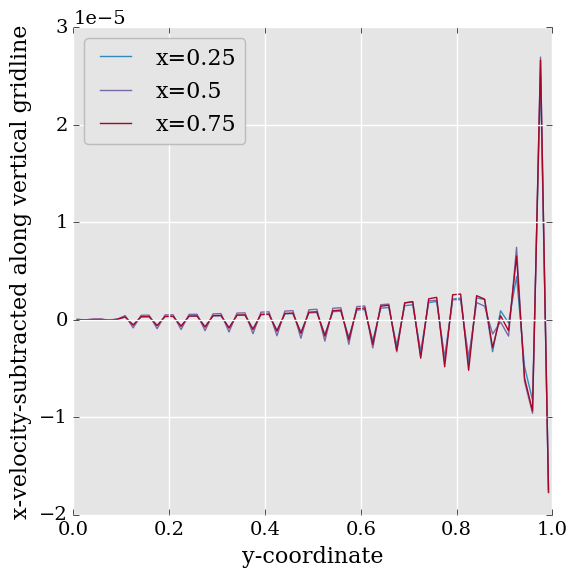

In [12]:
# plot subtracted x-velocity along vertical gridlines
petibm60.x_velocity_subtracted.plot_vertical_gridline_values([0.25, 0.50, 0.75])

[info] plotting field values along horizontal gridline(s) ... done
[info] plotting field values along horizontal gridline(s) ... done


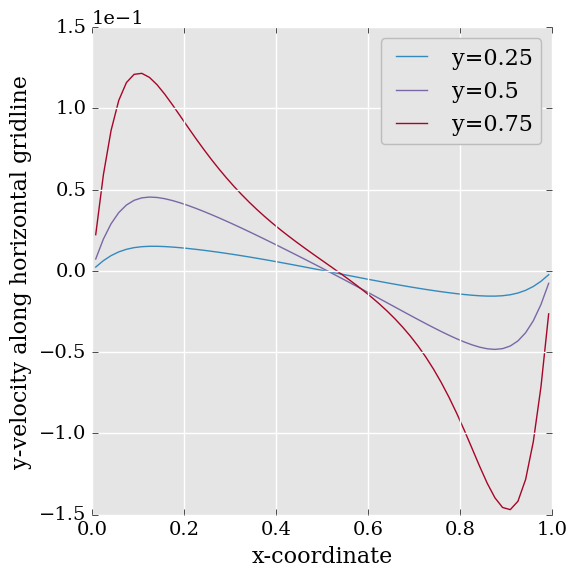

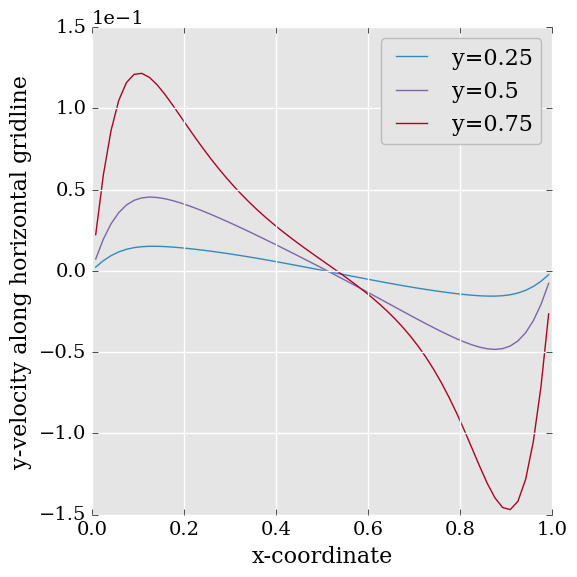

In [13]:
# plot y-velocity along horizontal gridlines
cuibm60.y_velocity.plot_horizontal_gridline_values([0.25, 0.50, 0.75])
petibm60.y_velocity.plot_horizontal_gridline_values([0.25, 0.50, 0.75])

[info] plotting field values along horizontal gridline(s) ... done


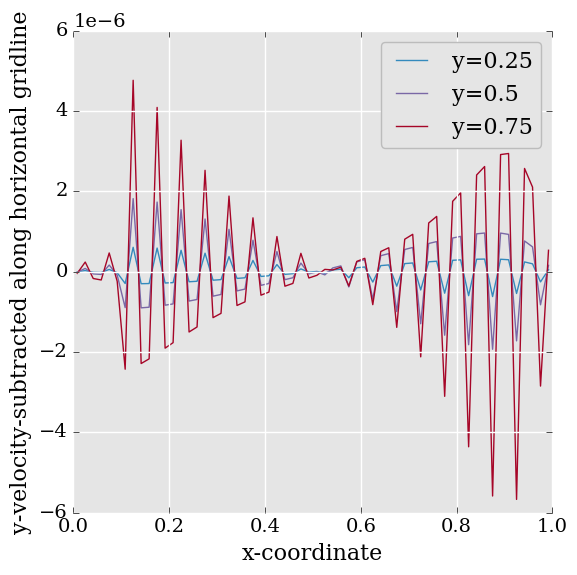

In [14]:
# ploy subtracted y-velocity along horizontal gridlines
petibm60.y_velocity_subtracted.plot_horizontal_gridline_values([0.25, 0.50, 0.75])

# grid: 180x180

In [15]:
gridline_size = 180
# create cuIBM case and read velocity from files
cuibm_directory = '{}/{}'.format(cuibm_series_directory, gridline_size)
cuibm180 = Simulation(software='cuibm', 
                     description='cuIBM', 
                     directory=cuibm_directory)
cuibm180.read_grid()
cuibm180.read_fields(['x-velocity', 'y-velocity'], 500)
# create PetIBM case and read velocity from files
petibm_directory = '{}/{}'.format(petibm_series_directory, gridline_size)
petibm180 = Simulation(software='petibm', 
                       description='PetIBM',
                       directory=petibm_directory)
petibm180.read_grid()
petibm180.read_fields(['x-velocity', 'y-velocity'], 500)
# subtract cuIBM solution from PetIBM one
petibm180.subtract(cuibm180, 'x-velocity')
petibm180.subtract(cuibm180, 'y-velocity')

[info] registering simulation ...
	- directory: /home/mesnardo/tmp/convergence_cuIBM/lidDrivenCavity20_atol12/180
	- description: cuIBM
	- software: cuibm
[info] reading grid from file ... done
[time-step 500] reading velocity field from file ... done
[info] registering simulation ...
	- directory: /home/mesnardo/tmp/convergence_PetIBM/lidDrivenCavity20_atol12/180
	- description: PetIBM
	- software: petibm
[info] reading the grid ... done
[time-step 500] reading velocity field ... done
x_velocity_subtracted
y_velocity_subtracted


[info] plotting field values along vertical gridline(s) ... done
[info] plotting field values along vertical gridline(s) ... done


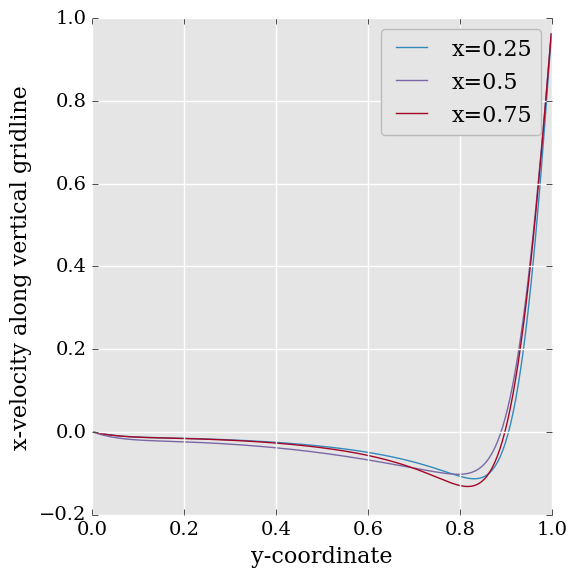

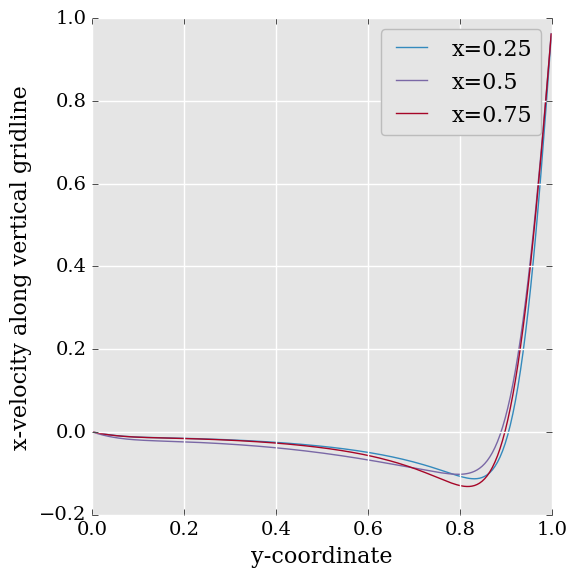

In [16]:
# plot x-velocity along vertical gridlines
cuibm180.x_velocity.plot_vertical_gridline_values([0.25, 0.50, 0.75])
petibm180.x_velocity.plot_vertical_gridline_values([0.25, 0.50, 0.75])

[info] plotting field values along vertical gridline(s) ... done


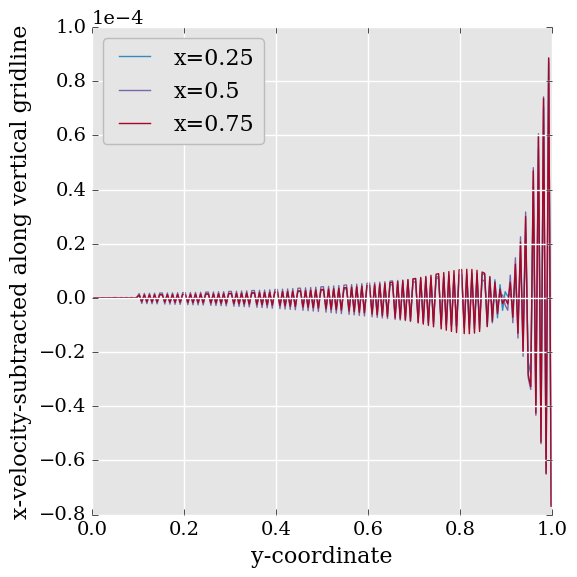

In [17]:
# plot subtracted x-velocity along vertical gridlines
petibm180.x_velocity_subtracted.plot_vertical_gridline_values([0.25, 0.50, 0.75])

[info] plotting field values along horizontal gridline(s) ... done
[info] plotting field values along horizontal gridline(s) ... done


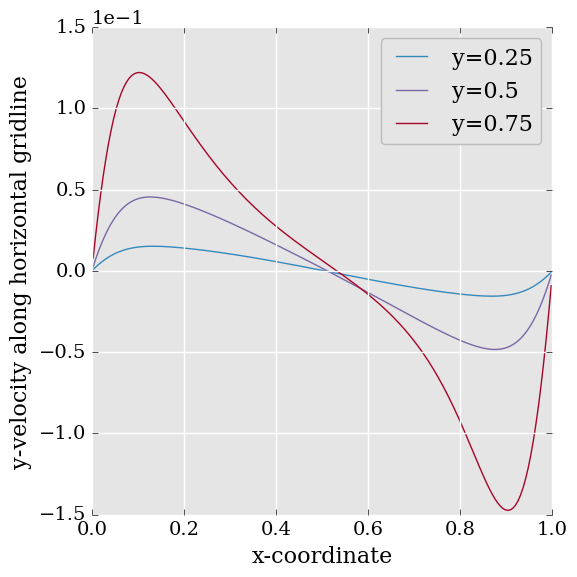

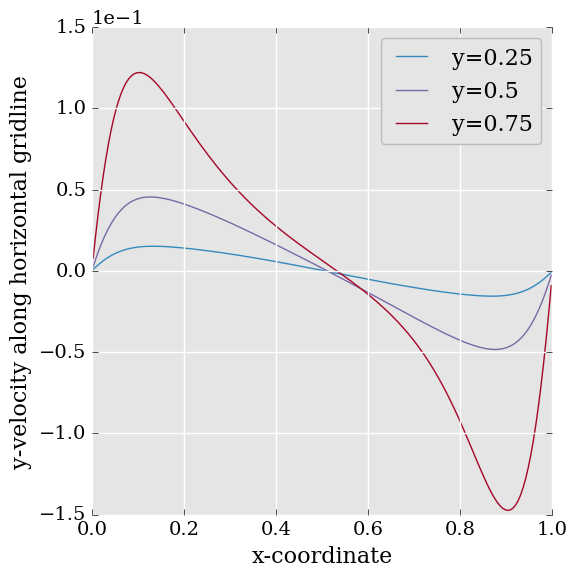

In [18]:
# plot y-velocity along horizontal gridlines
cuibm180.y_velocity.plot_horizontal_gridline_values([0.25, 0.50, 0.75])
petibm180.y_velocity.plot_horizontal_gridline_values([0.25, 0.50, 0.75])

[info] plotting field values along horizontal gridline(s) ... done
[info] plotting field values along horizontal gridline(s) ... done


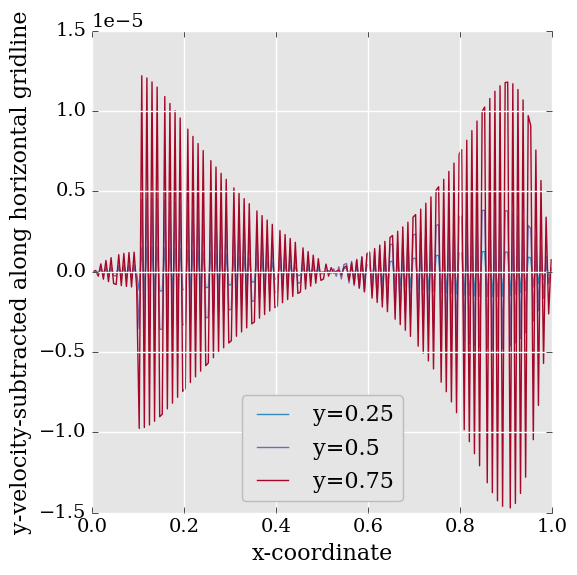

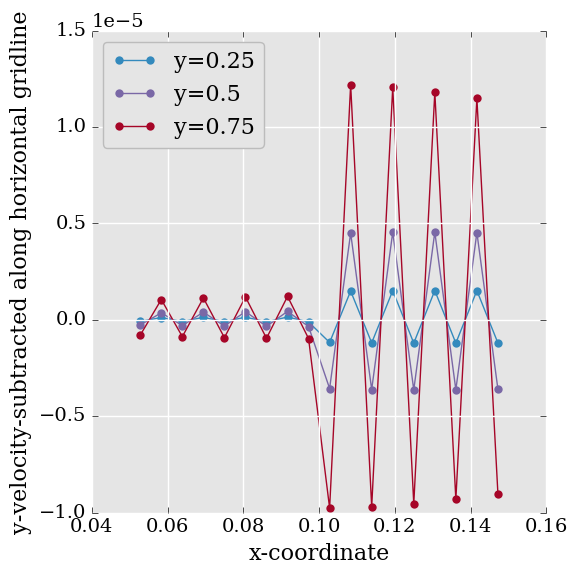

In [19]:
# plot subtracted y-velocity along horizontal gridlines
petibm180.y_velocity_subtracted.plot_horizontal_gridline_values([0.25, 0.50, 0.75])
# zoom over restricted interval
petibm180.y_velocity_subtracted.plot_horizontal_gridline_values([0.25, 0.50, 0.75], 
                                                        boundaries=(0.05, 0.15),
                                                        plot_settings={'marker': 'o'})

[info] plotting field values along horizontal gridline(s) ... done


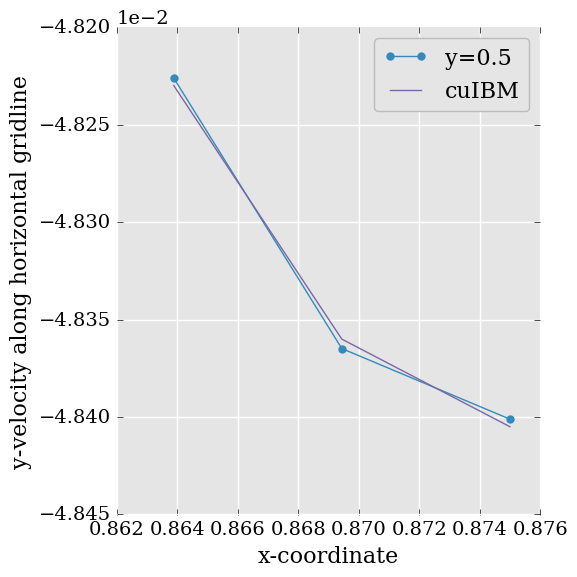

In [20]:
# compare PetIBM values with cuIBM ones over restricted interval
data = (cuibm180.y_velocity.x, 
        cuibm180.y_velocity.get_horizontal_gridline_values(0.5))
petibm180.y_velocity.plot_horizontal_gridline_values(0.5, 
                         plot_settings={'marker': 'o', 'zorder': 10},
                         boundaries=(0.86, 0.88),
                         validation_data=data,
                         validation_plot_settings={'label': 'cuIBM', 'zorder': 10})

# grid: 540x540

In [21]:
gridline_size = 540
# create cuIBM case and read velocity from files
cuibm_directory = '{}/{}'.format(cuibm_series_directory, gridline_size)
cuibm540 = Simulation(software='cuibm', 
                      description='cuIBM', 
                      directory=cuibm_directory)
cuibm540.read_grid()
cuibm540.read_fields(['x-velocity', 'y-velocity'], 500)
# create PetIBM case and read velocity from files
petibm_directory = '{}/{}'.format(petibm_series_directory, gridline_size)
petibm540 = Simulation(software='petibm', 
                       description='PetIBM',
                       directory=petibm_directory)
petibm540.read_grid()
petibm540.read_fields(['x-velocity', 'y-velocity'], 500)
# subtract cuIBM solution from PetIBM one
petibm540.subtract(cuibm540, 'x-velocity')
petibm540.subtract(cuibm540, 'y-velocity')

[info] registering simulation ...
	- directory: /home/mesnardo/tmp/convergence_cuIBM/lidDrivenCavity20_atol12/540
	- description: cuIBM
	- software: cuibm
[info] reading grid from file ... done
[time-step 500] reading velocity field from file ... done
[info] registering simulation ...
	- directory: /home/mesnardo/tmp/convergence_PetIBM/lidDrivenCavity20_atol12/540
	- description: PetIBM
	- software: petibm
[info] reading the grid ... done
[time-step 500] reading velocity field ... done
x_velocity_subtracted
y_velocity_subtracted


[info] plotting field values along vertical gridline(s) ... done
[info] plotting field values along vertical gridline(s) ... done


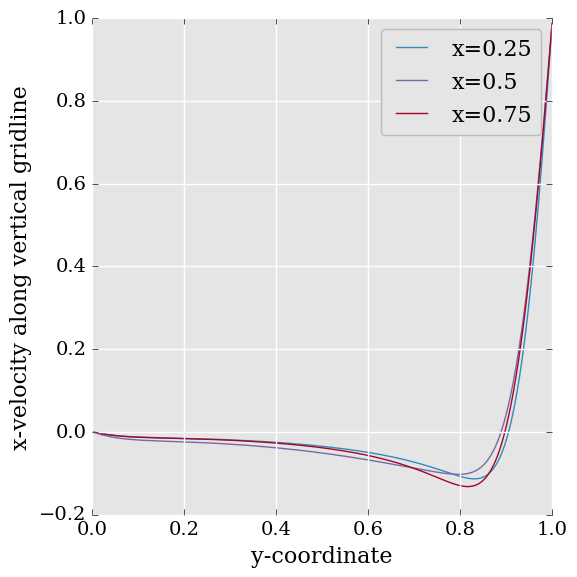

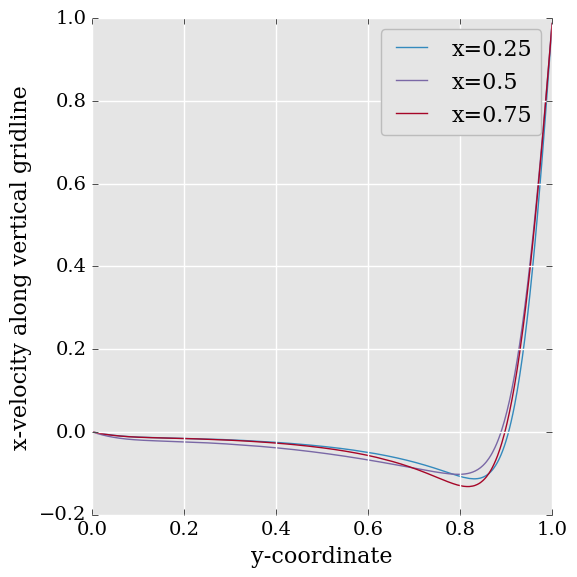

In [22]:
# plot x-velocity along vertical gridlines
cuibm540.x_velocity.plot_vertical_gridline_values([0.25, 0.50, 0.75])
petibm540.x_velocity.plot_vertical_gridline_values([0.25, 0.50, 0.75])

[info] plotting field values along vertical gridline(s) ... done
[info] plotting field values along vertical gridline(s) ... done


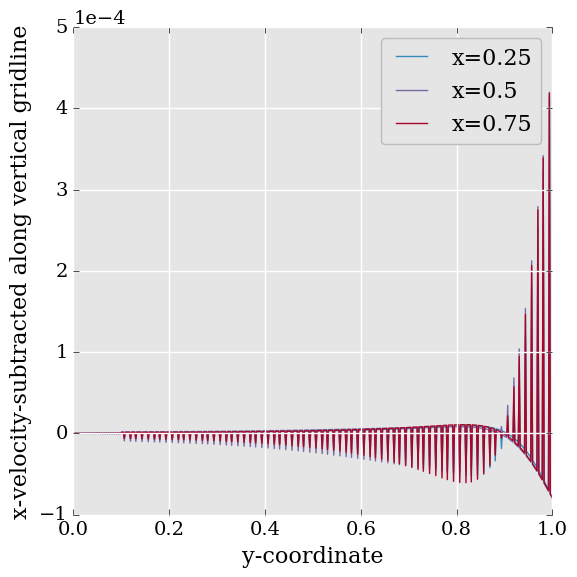

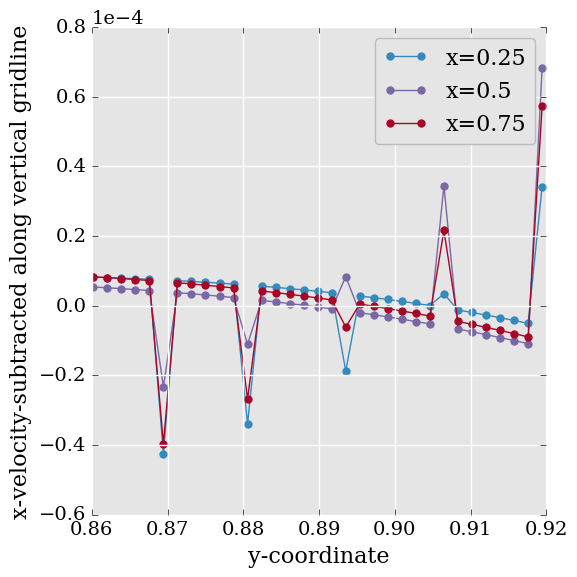

In [23]:
# plot subtracted x-velocity along vertical gridlines
petibm540.x_velocity_subtracted.plot_vertical_gridline_values([0.25, 0.50, 0.75])
# zoom over restricted interval
petibm540.x_velocity_subtracted.plot_vertical_gridline_values([0.25, 0.50, 0.75],
                                                    boundaries=(0.86, 0.92),
                                                    plot_settings={'marker': 'o'})

[info] plotting field values along horizontal gridline(s) ... done
[info] plotting field values along horizontal gridline(s) ... done


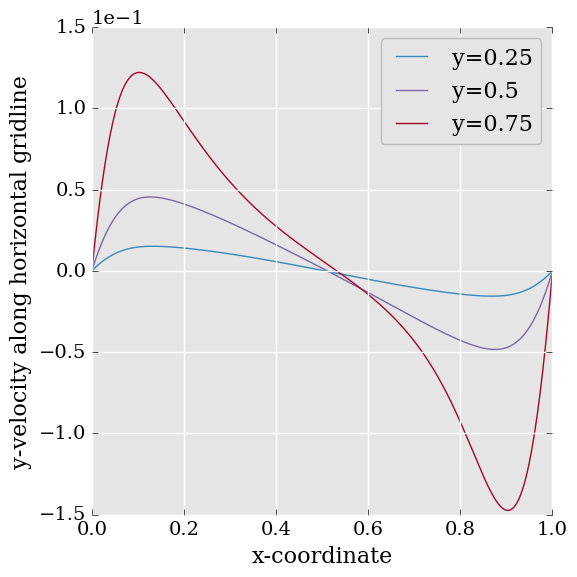

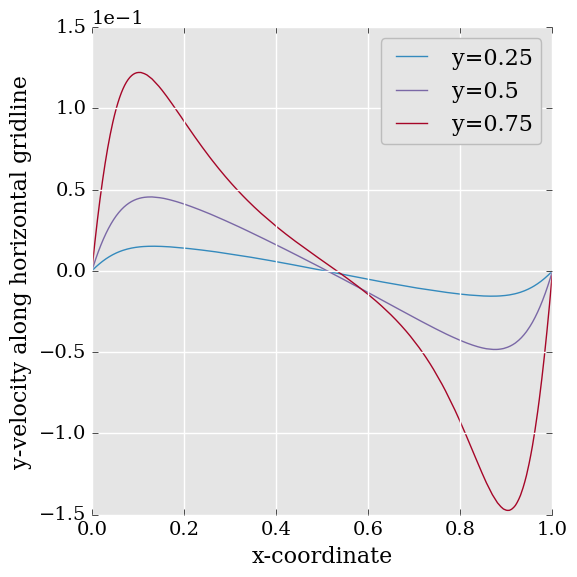

In [24]:
# plot y-velocity along horizontal gridlines
cuibm540.y_velocity.plot_horizontal_gridline_values([0.25, 0.50, 0.75])
petibm540.y_velocity.plot_horizontal_gridline_values([0.25, 0.50, 0.75])

[info] plotting field values along horizontal gridline(s) ... done
[info] plotting field values along horizontal gridline(s) ... done
[info] plotting field values along horizontal gridline(s) ... done


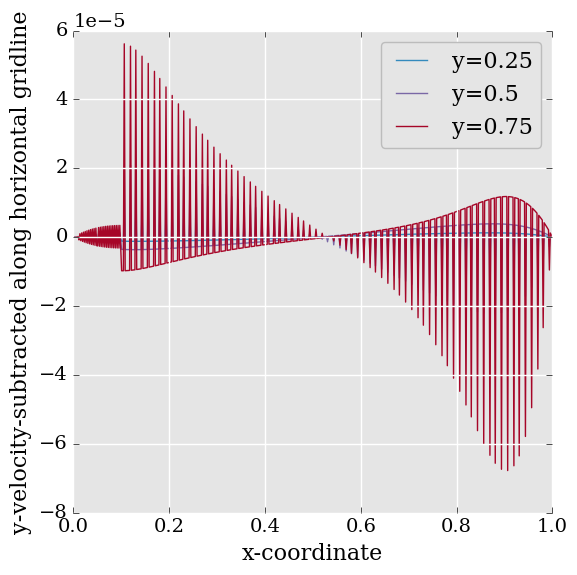

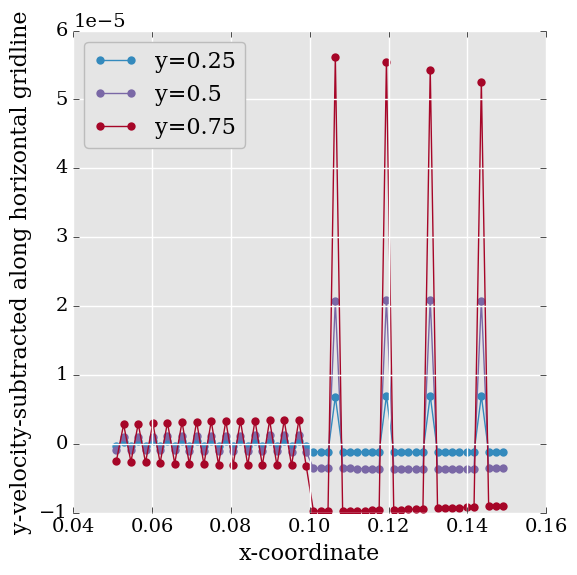

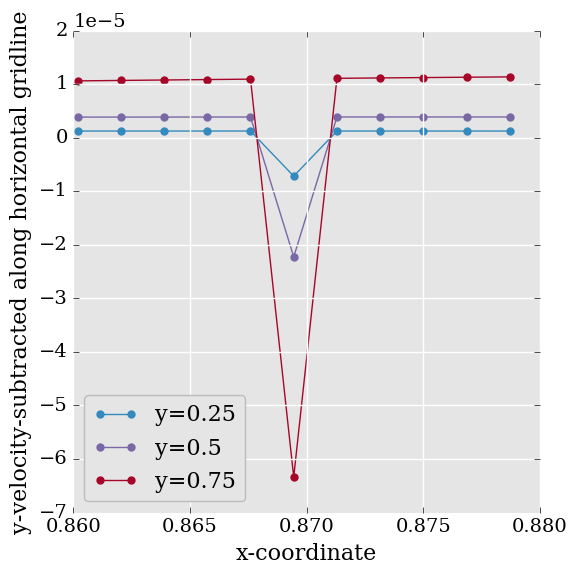

In [25]:
# plot subtracted y-velocity along horizontal gridlines
petibm540.y_velocity_subtracted.plot_horizontal_gridline_values([0.25, 0.50, 0.75])
# zoom over restricted interval
petibm540.y_velocity_subtracted.plot_horizontal_gridline_values([0.25, 0.50, 0.75], 
                                                        boundaries=(0.05, 0.15),
                                                        plot_settings={'marker': 'o'})
petibm540.y_velocity_subtracted.plot_horizontal_gridline_values([0.25, 0.50, 0.75], 
                                                        boundaries=(0.86, 0.88),
                                                        plot_settings={'marker': 'o'})

[info] plotting field values along horizontal gridline(s) ... done
[info] plotting field values along horizontal gridline(s) ... done


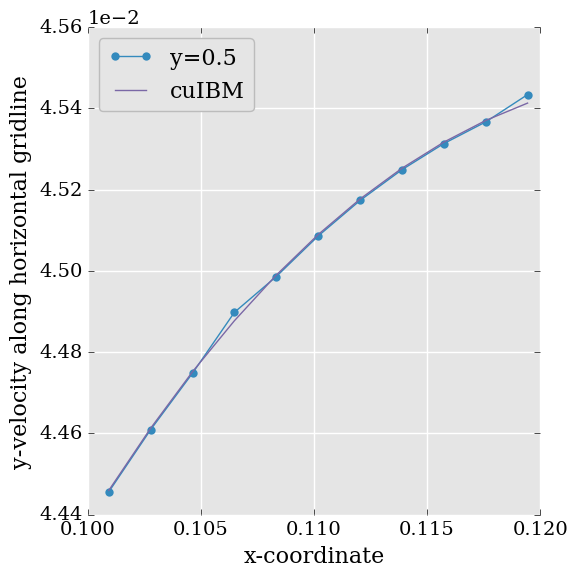

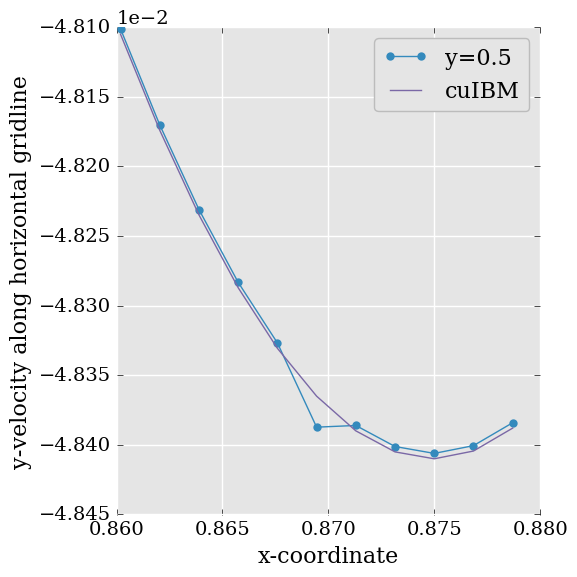

In [26]:
# compare PetIBM values with cuIBM ones over restricted interval
data = (cuibm540.y_velocity.x, 
        cuibm540.y_velocity.get_horizontal_gridline_values(0.5))
petibm540.y_velocity.plot_horizontal_gridline_values(0.5,
                         plot_settings={'marker': 'o', 'zorder': 10},
                         boundaries=(0.10, 0.12),
                         validation_data=data, 
                         validation_plot_settings={'label': 'cuIBM', 'zorder': 10})
petibm540.y_velocity.plot_horizontal_gridline_values(0.5,
                         plot_settings={'marker': 'o', 'zorder': 10},
                         boundaries=(0.86, 0.88),
                         validation_data=data, 
                         validation_plot_settings={'label': 'cuIBM', 'zorder': 10})

# grid: 1620x1620

In [27]:
gridline_size = 1620
# create cuIBM case and read velocity from files
cuibm_directory = '{}/{}'.format(cuibm_series_directory, gridline_size)
cuibm1620 = Simulation(software='cuibm', 
                       description='cuIBM', 
                       directory=cuibm_directory)
cuibm1620.read_grid()
cuibm1620.read_fields(['x-velocity', 'y-velocity'], 500)
# create PetIBM case and read velocity from files
petibm_directory = '{}/{}'.format(petibm_series_directory, gridline_size)
petibm1620 = Simulation(software='petibm', 
                        description='PetIBM',
                        directory=petibm_directory)
petibm1620.read_grid()
petibm1620.read_fields(['x-velocity', 'y-velocity'], 500)
# subtract cuIBM solution from PetIBM one
petibm1620.subtract(cuibm1620, 'x-velocity')
petibm1620.subtract(cuibm1620, 'y-velocity')

[info] registering simulation ...
	- directory: /home/mesnardo/tmp/convergence_cuIBM/lidDrivenCavity20_atol12/1620
	- description: cuIBM
	- software: cuibm
[info] reading grid from file ... done
[time-step 500] reading velocity field from file ... done
[info] registering simulation ...
	- directory: /home/mesnardo/tmp/convergence_PetIBM/lidDrivenCavity20_atol12/1620
	- description: PetIBM
	- software: petibm
[info] reading the grid ... done
[time-step 500] reading velocity field ... done
x_velocity_subtracted
y_velocity_subtracted


[info] plotting field values along vertical gridline(s) ... done
[info] plotting field values along vertical gridline(s) ... done


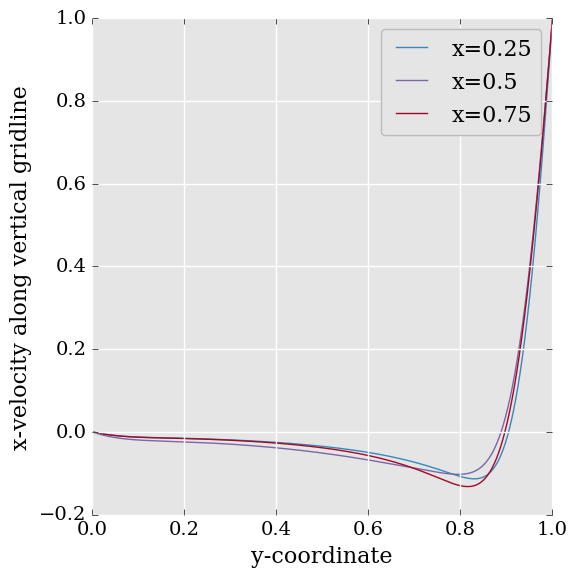

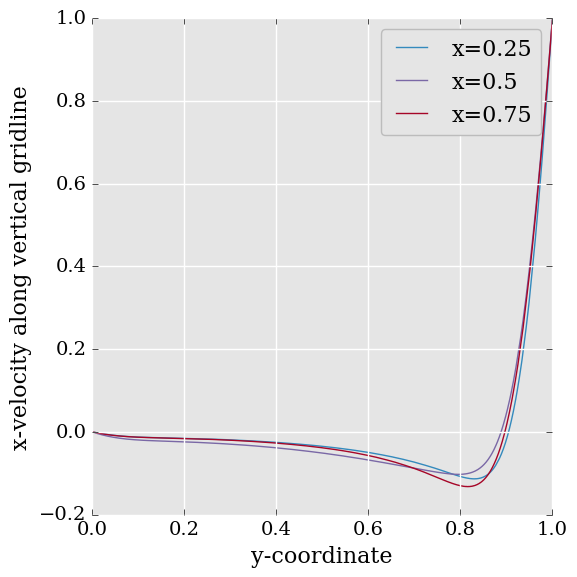

In [28]:
# plot x-velocity along vertical gridlines
cuibm1620.x_velocity.plot_vertical_gridline_values([0.25, 0.50, 0.75])
petibm1620.x_velocity.plot_vertical_gridline_values([0.25, 0.50, 0.75])

[info] plotting field values along vertical gridline(s) ... done


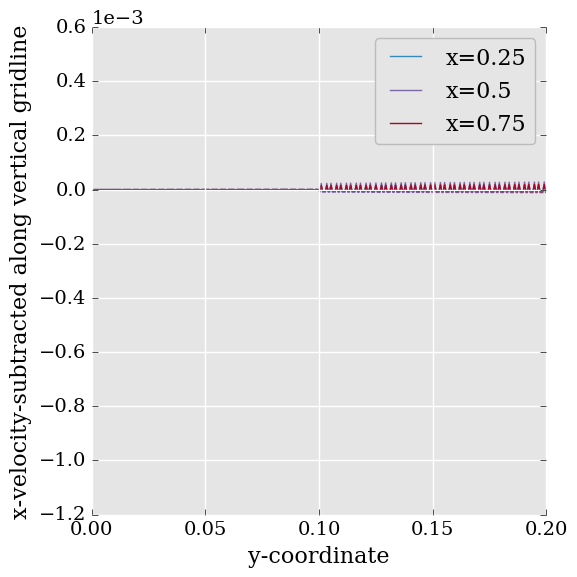

In [29]:
# plot subtracted x-velocity along vertical gridlines
petibm1620.x_velocity_subtracted.plot_vertical_gridline_values([0.25, 0.50, 0.75],
                                                plot_limits=[0.0, 0.2, None, None])

[info] plotting field values along horizontal gridline(s) ... done
[info] plotting field values along horizontal gridline(s) ... done


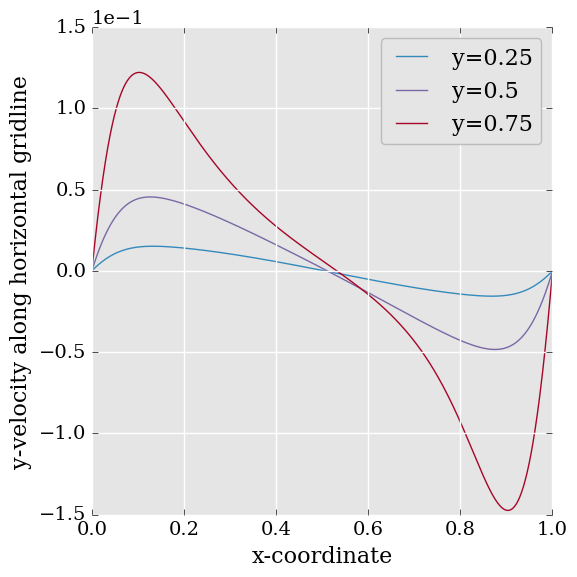

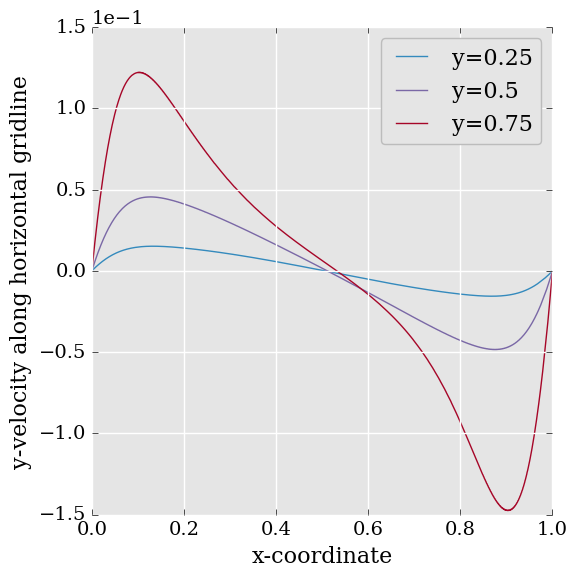

In [30]:
# plot y-velocity along horizontal gridlines
cuibm1620.y_velocity.plot_horizontal_gridline_values([0.25, 0.50, 0.75])
petibm1620.y_velocity.plot_horizontal_gridline_values([0.25, 0.50, 0.75])

[info] plotting field values along horizontal gridline(s) ... done
[info] plotting field values along horizontal gridline(s) ... done
[info] plotting field values along horizontal gridline(s) ... done


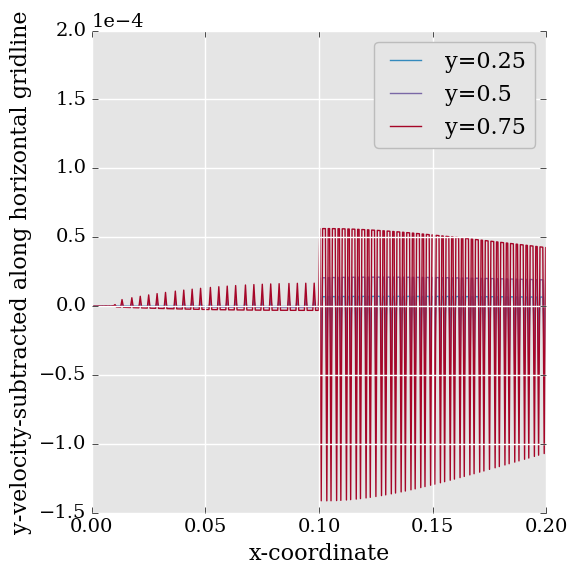

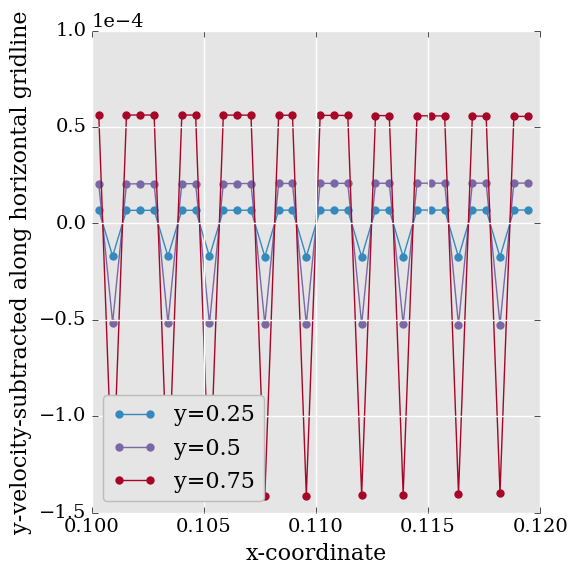

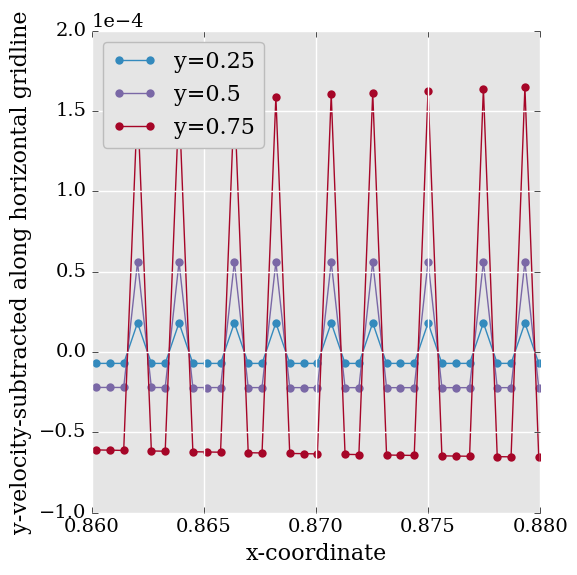

In [31]:
# plot subtracted y-velocity along horizontal gridlines
petibm1620.y_velocity_subtracted.plot_horizontal_gridline_values([0.25, 0.50, 0.75],
                                                         plot_limits=[0.0, 0.2, None, None])
# zoom over resctricted interval
petibm1620.y_velocity_subtracted.plot_horizontal_gridline_values([0.25, 0.50, 0.75], 
                                                            boundaries=(0.10, 0.12),
                                                            plot_settings={'marker': 'o'})
petibm1620.y_velocity_subtracted.plot_horizontal_gridline_values([0.25, 0.50, 0.75], 
                                                            boundaries=(0.86, 0.88),
                                                            plot_settings={'marker': 'o'})

[info] plotting field values along horizontal gridline(s) ... done
[info] plotting field values along horizontal gridline(s) ... done


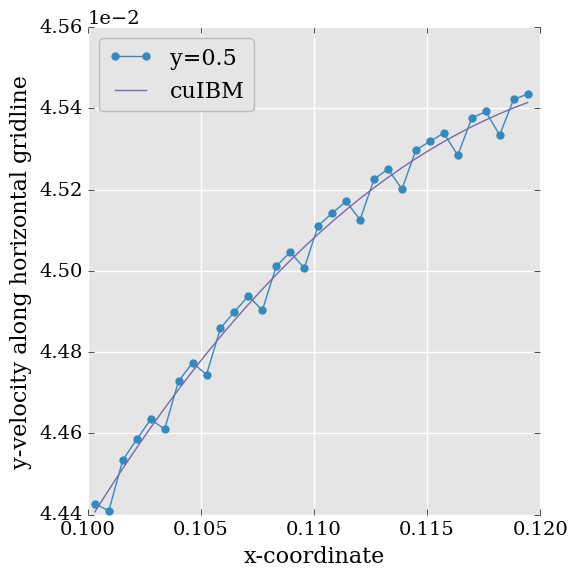

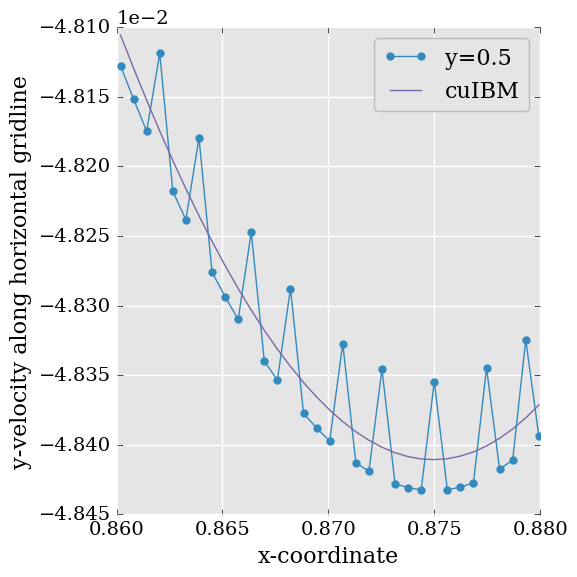

In [32]:
# compare PetIBM values with cuIBM ones over restricted interval
data = (cuibm1620.y_velocity.x, 
        cuibm1620.y_velocity.get_horizontal_gridline_values(0.5))
petibm1620.y_velocity.plot_horizontal_gridline_values(0.5,
                  plot_settings={'marker': 'o', 'zorder': 10},
                  boundaries=(0.10, 0.12),
                  validation_data=data,
                  validation_plot_settings={'label': 'cuIBM', 'zorder': 10})
petibm1620.y_velocity.plot_horizontal_gridline_values(0.5,
                  plot_settings={'marker': 'o', 'zorder': 10},
                  boundaries=(0.86, 0.88),
                  validation_data=data,
                  validation_plot_settings={'label': 'cuIBM', 'zorder': 10})